# Chapter 1. Gaining Early Insights from Textual Data

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import random

import seaborn as sns
sns.set()

In [17]:
DATASET = Path("../DATASETS/un-general-debate/un-general-debates-blueprint.csv")

In [18]:
df = pd.read_csv(DATASET)
df.sample(4)

,session,year,country,country_name,speaker,position,text
3545,49,1994,SWZ,Eswatini,Prince Dlamini,Prime Minister,I bring with me the\ngreetings and good wishes...
525,29,1974,PAK,Pakistan,Mr. Ahmed,NaN,"Mr. President, it gives my delegation great pl..."
4812,56,2001,UKR,Ukraine,Anatoliy M. Zlenko,Minister for Foreign Affairs,﻿Allow me at the outset to\ncongratulate the P...
3053,47,1992,ARM,Armenia,TER-PETROSSIAN,President,"At the \noutset, on behalf of the Republic of ..."


## Getting an overview of the Data with pandas

* Calculate summary statistics.
* Check for missing values.
* Plot distributions of interesting attributes.
* Compare distributions across categories.
* Visualize developments over time.

### Calculating Summary Statistics for Columns

In [19]:
df["length"] = df["text"].str.len()
df.describe().T # dataset contain speaches from the 25th to the 70th un debates (1970 - 2015)

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [20]:
df[["country", "speaker"]].describe(include='O').T 
# The dataset contain 199 unique countries & 5428 unique speakers.

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


### Checking Missing Values

In [21]:
# Checking missing values

df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [22]:
# we need to replace the missing value with some generic values
df['speaker'].fillna('unknown', inplace = True)

In [23]:
# there is a chance, the speaker's name is spelled differently.
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

### Plotting Value Distributions

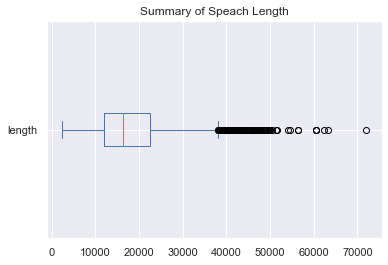

In [24]:
df["length"].plot(kind="box", vert=False, title="Summary of Speach Length");
# 50% of the speaches have a length rougly 12000 and 22000, with the median at about 16000.

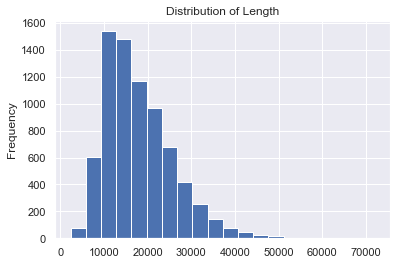

In [25]:
df["length"].plot(kind="hist", bins=20, title='Distribution of Length');

### Comparing Value Distributions Across Categories

In [26]:
# Peculiarities in the data often become visible when different subsets of the data are examined

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS', 'IND'])

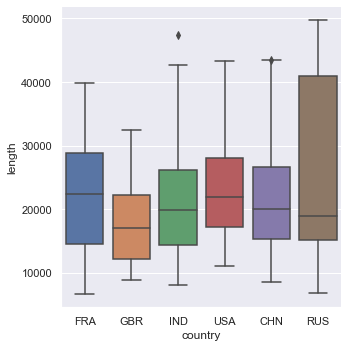

In [27]:
sns.catplot(data = df[where], x = 'country', y = 'length', kind = 'box');

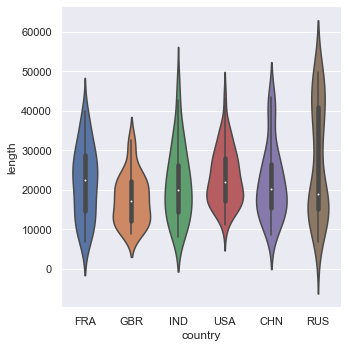

In [28]:
sns.catplot(data=df[where], x='country', y='length', kind='violin')
# RUS is much larger than for GBR but existence of multiple peaks, 
# as in Russia, only becomes apparent in the violin plot.

### Visualizing Developments Over Time

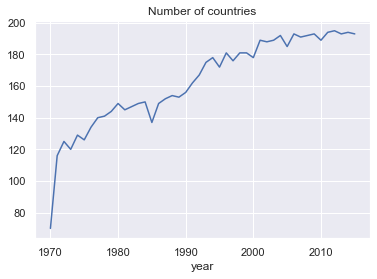

In [29]:
df.groupby('year').size().plot(title="Number of countries");

# this reflects the development of UN in each year.

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

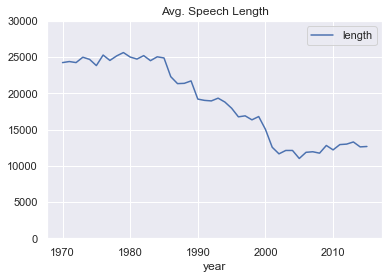

In [30]:
df.groupby('year').agg({'length': 'mean'}).plot(title="Avg. Speech Length", ylim=(0,30000))

#the speech length needed to decrease with more countries entering the debates

## Building a Simple Text Preprocessing Pipeline


### Performing Tokenization with Regular Expressions

In [31]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [32]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


### Treating Stopwords

In [33]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [34]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [35]:
include_stopwords = {"dear", "regards", "must", "would", "also"}
exclude_stopwords = {"against"}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

### Processing a Pipeline with One Line of Code

In [36]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [37]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [38]:
df['num_tokens'] = df['tokens'].map(len)

In [39]:
df.head(3)

,session,year,country,country_name,speaker,position,text,length,tokens,num_tokens
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419,"[may, first, convey, president, congratulation...",4125
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286,"[fortunate, coincidence, precisely, time, unit...",2327
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,31839,"[pleasure, extend, mr, president, warmest, con...",2545


## Blueprints for Word Frequency Analysis

### Counting Words with a Counter

In [40]:
from collections import Counter

In [41]:
tokens = tokenize("She likes my cats and my cats like my sofa")

In [42]:
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [43]:
# Counter can be incrementally updated

more_token = tokenize("She likes my dogs too")
counter.update(more_token)

In [44]:
print(counter)

Counter({'my': 4, 'She': 2, 'likes': 2, 'cats': 2, 'and': 1, 'like': 1, 'sofa': 1, 'dogs': 1, 'too': 1})


In [45]:
counter = Counter()

df['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
7502    None
7503    None
7504    None
7505    None
7506    None
Name: tokens, Length: 7507, dtype: object

In [46]:
print(counter.most_common(4))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421)]


In [47]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [48]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [49]:
count_words(df, column='text', 
        preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
enfranchising,2
interrelate,2
compositions,2


### Creating a Frequency Diagram

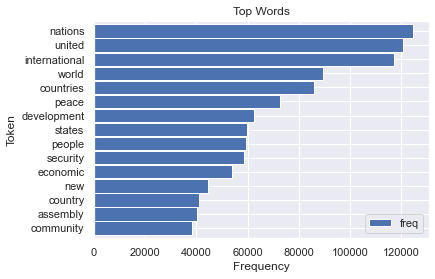

In [282]:
ax = freq_df.head(15).plot(kind="barh", width=.95)

ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words');

### Creating Word Clouds

In [53]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [65]:
text = df.query("year==2015 and country=='USA'")['text'].values[0]

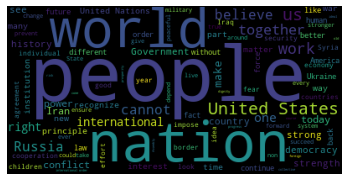

In [66]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)

plt.imshow(wc)
plt.axis("off");

In [75]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

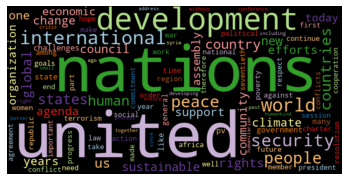

In [76]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)

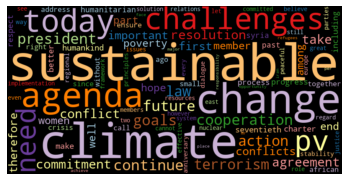

In [288]:
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

### Ranking with TF-IDF

In [84]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [86]:
idf_df = compute_idf(df)

C:\Users\HP\AppData\Local\Temp/ipykernel_3192/4234653083.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [87]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

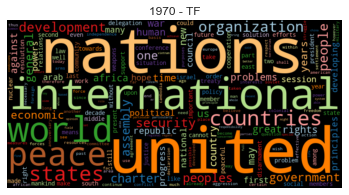

In [88]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
wordcloud(freq_1970['freq'], title='1970 - TF',
          stopwords=['twenty-fifth', 'twenty-five'])

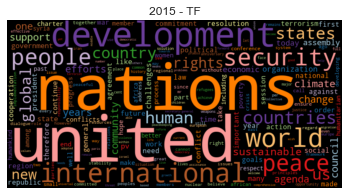

In [89]:
wordcloud(freq_2015['freq'], title='2015 - TF',
          stopwords=['seventieth'])

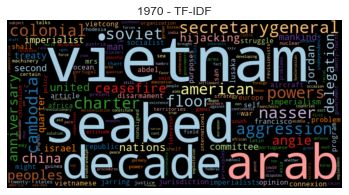

In [90]:
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF',
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

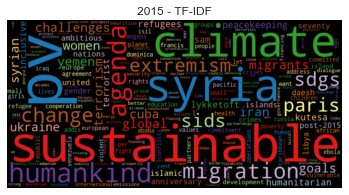

In [91]:
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF',
          stopwords=['seventieth'])

### Finding a Keyword-in-context

In [109]:
from textacy.extract.kwic import keyword_in_context

In [112]:

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True,
                              window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [113]:
kwic(df[df['year'] == 2015]['text'], 'pv', print_samples=5, window=20)

5 random samples out of 468 contexts for 'pv':
 Assembly (see A/70/  PV  .3). The proliferati
4 
 01/10/2015 A/70/  PV  .23 that require coo
-29876 13/26 
 A/70/  PV  .24 01/10/2015 the c
5-29701 7/28 
 A/70/  PV  .21 30/09/2015 Strat
5 
 29/09/2015 A/70/  PV  .18 country. The dea


In [117]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=10, window=40)

10 random samples out of 73 contexts for 'sdgs':
ously proposed remedies. Above all, the   SDGs   proclaim in bold letters the concept of
k of the Sustainable Development Goals (  SDGs  ). The new 2030 Agenda for Sustainable D
late the Sustainable Development Goals (  SDGs  ) 15-29664 21/25 
 A/70/PV.23 01/10/2015
ving the Sustainable Development Goals (  SDGs  ) will require countries, both developed
ts so well articulated in Goal 3 of the   SDGs  . His Majesty is expected to launch the 
that the Sustainable Development Goals (  SDGs  ) will be an effective tool in global ef
ure’s deterioration. We the people need   SDGs   championed by good accountable leaders.
ving the Sustainable Development Goals (  SDGs  ), and we adopted the financing for deve
hould stress that for the newly adopted   SDGs   to be truly global, they must be practi
he Millennium Development Goals and the   SDGs  . Those policies cover the areas of popu


### Analysing N-Grams

In [121]:
def ngrams(tokens, n=2, sep=" "):
    ngrams_ = [sep.join(ngram) for ngram in 
              zip(*[tokens[i:] for i in range(n)])]
    return ngrams_

In [119]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)

In [125]:
print(" | ".join(ngrams(tokens, 2)))

the visible | visible manifestation | manifestation of | of the | the global | global climate | climate change


In [128]:
def ngrams(tokens, n=2, sep=" ", stopwords=set()):
    ngram = [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]
    return ngram

In [129]:
print("Bigrams:", " | ".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", " | ".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation | global climate | climate change
Trigrams: global climate change


In [130]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [131]:
idf_df = pd.concat([idf_df, compute_idf(df, "bigrams", min_df=10)])
freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

C:\Users\HP\AppData\Local\Temp/ipykernel_3192/4234653083.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


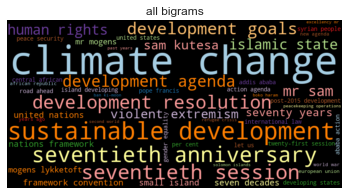

In [132]:
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

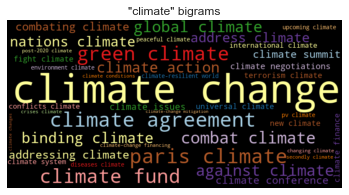

In [328]:
where = freq_df.index.str.contains("climate")
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## Comparing Frequencies Across Time Intervals and Categories

### Creating Frequency Timelines

In [172]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [173]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']


In [174]:
print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [176]:
def count_keywords_by(df, by, keywords, column='tokens'):

    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)

    return freq_df.groupby(by=by).sum().sort_values(by)

In [177]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [144]:
freq_df.head(4)

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266


In [145]:
freq_df.tail(4)

,nuclear,terrorism,climate,freedom
year,,,,
2012,254,198,340,305
2013,260,216,349,177
2014,144,404,654,129
2015,246,378,662,148


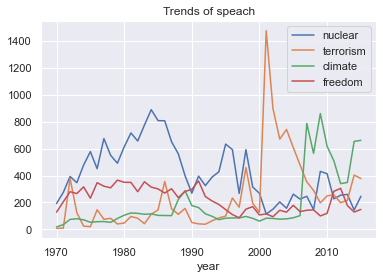

In [146]:
freq_df.plot(kind="line", title="Trends of speach");

### Creating Frequency Heatmap


In [147]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping',
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs', 'india']

In [153]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [154]:
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

In [155]:
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)


<AxesSubplot:xlabel='year'>

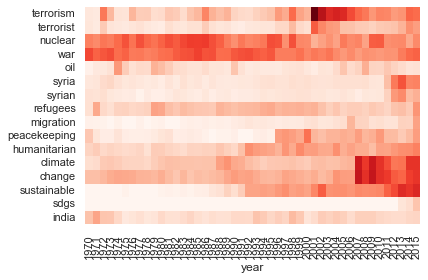

In [156]:
sns.heatmap(data=freq_df.T,
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")